In [1]:
%matplotlib inline
import theano
import theano.tensor as tt

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../theano_ops")
from theano_ops.celerite.factor import FactorOp
from theano_ops.celerite.solve import SolveOp
from theano_ops.celerite import terms
from theano_ops.celerite.celerite import log_likelihood

import time

## Generate data

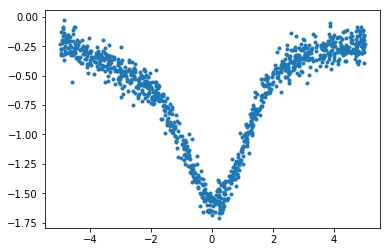

In [2]:
from celerite.modeling import Model

# Define the celerite model for mock data, generated from a RealTerm gp kernel
class MeanModel(Model):
    parameter_names = ("alpha", "ell", "log_sigma2")

    def get_value(self, t):
        return self.alpha * np.exp(-0.5*(t-self.ell)**2 * np.exp(-self.log_sigma2))

    # This method is optional but it can be used to compute the gradient of the
    # cost function below.
    def compute_gradient(self, t):
        e = 0.5*(t-self.ell)**2 * np.exp(-self.log_sigma2)
        dalpha = np.exp(-e)
        dell = self.alpha * dalpha * (t-self.ell) * np.exp(-self.log_sigma2)
        dlog_s2 = self.alpha * dalpha * e
        return np.array([dalpha, dell, dlog_s2])

mean_model = MeanModel(alpha=-1.0, ell=0.1, log_sigma2=np.log(0.8))

N = 1000

x_np = np.sort(np.random.uniform(-5, 5, N))
diag_np = np.random.uniform(0.05, 0.1, len(x_np))

K = 0.1*np.exp(-0.5*(x_np[:, None] - x_np[None, :])**2/10.5)
K[np.diag_indices(len(x_np))] += diag_np**2
y_np = np.random.multivariate_normal(mean_model.get_value(x_np), K)

plt.plot(x_np, y_np, '.')

## Celerite via theano 

In [3]:
diag = tt._shared(diag_np)
x = tt._shared(x_np)
y = tt._shared(y_np)

# Initialize celerite_theano kernel
sigma = tt.dscalar('S0')
rho = tt.dscalar('w0')

kernel = terms.Matern32Term(sigma=sigma, rho=rho)

In [4]:
loglike_theano = log_likelihood(kernel, 0., diag, x, y)

# Likelihood
f = theano.function(inputs=[sigma, rho], outputs=loglike_theano, on_unused_input="ignore")
# Gradients
g = theano.function(inputs=[sigma, rho], outputs=theano.grad(loglike_theano, [sigma, rho]), on_unused_input="ignore")

In [5]:
f(0.5, 2.)

array(314.46799746)

In [6]:
g(0.5, 2.)

[array(-16.67669942), array(8.31798512)]

In [7]:
%timeit f(0.5, 2.)

356 µs ± 8.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
%timeit g(0.5, 2.)

790 µs ± 26.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Celerite via tensorflow 

In [9]:
import tensorflow as tf
session = tf.get_default_session()
if session is None:
    session = tf.InteractiveSession()

import celeriteflow as cf

In [12]:
T = tf.float64

x_tf = tf.constant(x_np)
diag_tf = tf.constant(diag_np)
y_tf = tf.constant(y_np)

sigma_tf = tf.Variable(0.5, dtype=T)
rho_tf = tf.Variable(2., dtype=T)

session.run(tf.global_variables_initializer())

kernel_tf = cf.terms.Matern32Term(sigma=sigma_tf, rho=rho_tf)

gp_tf = cf.GaussianProcess(kernel_tf, x_tf, y_tf, diag_tf)
loglike_tf = gp_tf.log_likelihood
grad_loglike_tf = tf.gradients(loglike_tf, [sigma_tf, rho_tf])

In [13]:
loglike_tf.eval()

# loglike_tf.eval({S0_tf:1.2, w0_tf:5.4, Q_tf:5.})

# for i in range(10):
    

314.4679974556509

In [14]:
tf.get_default_session().run(grad_loglike_tf)

[-16.676699418752136, 8.317985124749894]

In [15]:
%timeit loglike_tf.eval()

638 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%timeit  tf.get_default_session().run(grad_loglike_tf)

1.47 ms ± 8.97 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Plain celerite

In [18]:
import celerite
from celerite import terms

# Set up the GP model
kernel_celerite = terms.Matern32Term(log_sigma=np.log(0.5), log_rho=np.log(2.))
gp_celerite = celerite.GP(kernel_celerite)
gp_celerite.compute(x_np, diag_np)
loglike_celerite = gp_celerite.log_likelihood(y_np)
loglike_celerite

1145.7756167960629

In [19]:
%timeit gp_celerite.log_likelihood(y_np)

47.4 µs ± 770 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
